# Проведение расчётов и исследований


* Создать дополнительный категориальный столбец, который покажет количество рекламаций по каждому клиенту отдельно: мало (≤1), средне (=2), много (>2).
* Рассчитать средний возраст респондентов по полу и стране
* Добавить категориальный столбец, разделив респондентов на три категории по возрасту: до 44 лет - молодой возраст, 45 - 59 лет - средний возраст, 60 лет и больше - пожилой возраст.
* Рассчитать среднюю комфортную температуру в зависимости от возрастной категории
* Рассчитать медианное значение температуры и влажности для каждого типа охлаждения

# Импорт необходимых библиотек и считывание файла

In [136]:
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import spearmanr, pearsonr, shapiro, chi2_contingency, ttest_ind, mannwhitneyu
# from phik.phik import phik_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [137]:
PATH_OUT = 'stage2.csv' 
df = pd.read_csv(PATH_OUT, sep=';',encoding='utf-8', skipinitialspace=True)
df.sample(3)


,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,скорость_воздуха,рост,вес,занавески,вентилятор,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций
47,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,40.0,NaN,...,0.06,NaN,NaN,0.0,0.0,NaN,NaN,NaN,28.9,0
378,2012.0,Зима,Влажный субтропический муссонный,Дели,Индия,Кондиционирование,NaN,NaN,35.0,Мужской,...,0.13,174.0,95.0,NaN,NaN,NaN,NaN,1.0,15.5,2
423,2012.0,Лето,Жаркий полузасушливый,Ахмедабад,Индия,Вентиляция,NaN,NaN,65.0,Мужской,...,1.43,157.5,45.0,NaN,1.0,1.0,NaN,NaN,29.5,0


# Проведение расчетов и исследований

## Создание кат столбца по кол-ву рекламаций

In [138]:
def claim(x):
    if x <= 1: 
        return 'мало' 
    elif x == 2: 
        return 'средне' 
    else: 
        return 'много'

In [139]:
df['количество_рекламаций_кат'] = df['количество_рекламаций'].apply(claim)

## Средний возраст по полу и стране + возраст_кат

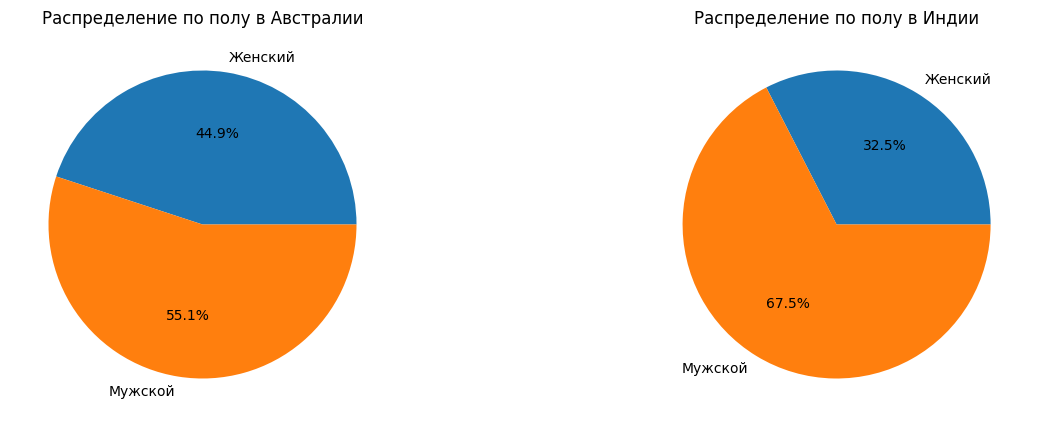

In [140]:
grouped_data = df.groupby(['страна', 'пол']).size()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].pie(grouped_data['Австралия'],
           labels=grouped_data['Австралия'].index, autopct='%1.1f%%')
axs[0].set_title('Распределение по полу в Австралии')


axs[1].pie(grouped_data['Индия'],
           labels=grouped_data['Индия'].index, autopct='%1.1f%%')
axs[1].set_title('Распределение по полу в Индии')


plt.show()

In [141]:
df.groupby(['страна', 'пол'])['возраст'].mean()

страна     пол    
Австралия  Женский    46.348315
           Мужской    42.614679
Индия      Женский    36.590909
           Мужской    38.298969
Name: возраст, dtype: float64

In [142]:
def age_cat(x):
    if x <= 44: 
        return 'молодой возраст'
    elif 45 <= x <= 59: 
        return 'средний возраст' 
    else: 
        return 'пожилой возраст'

df['возраст_кат'] = df['возраст'].apply(age_cat)

## Рассчитать ср.комф температуру по возрастным группам

In [143]:
df.groupby(['возраст_кат', 'предпочтительное_изменение_температуры'])['температура_воздуха_в_помещении'].mean()

возраст_кат      предпочтительное_изменение_температуры
молодой возраст  Без изменений                             24.267717
                 Теплее                                    25.020000
                 Холоднее                                  24.828000
пожилой возраст  Без изменений                             26.480000
                 Теплее                                    26.653846
                 Холоднее                                  27.461765
средний возраст  Без изменений                             23.948718
                 Теплее                                    24.688889
                 Холоднее                                  24.215000
Name: температура_воздуха_в_помещении, dtype: float64

In [144]:
res = df.groupby(['возраст_кат', 'предпочтительное_изменение_температуры'])['температура_воздуха_в_помещении'].mean().reset_index()
res[res['предпочтительное_изменение_температуры'] == 'Без изменений']

,возраст_кат,предпочтительное_изменение_температуры,температура_воздуха_в_помещении
0,молодой возраст,Без изменений,24.267717
3,пожилой возраст,Без изменений,26.480000
6,средний возраст,Без изменений,23.948718


## Рассчитать медианное знач. темп и влажности для каждого типа охлаждения

In [145]:
df.groupby('способ_охлаждения')[['температура_воздуха_в_помещении', 'rh']].median()

,температура_воздуха_в_помещении,rh
способ_охлаждения,,
Вентиляция,25.2,46.00
Кондиционирование,24.3,42.45
Смешанный,24.6,56.40


# Графики

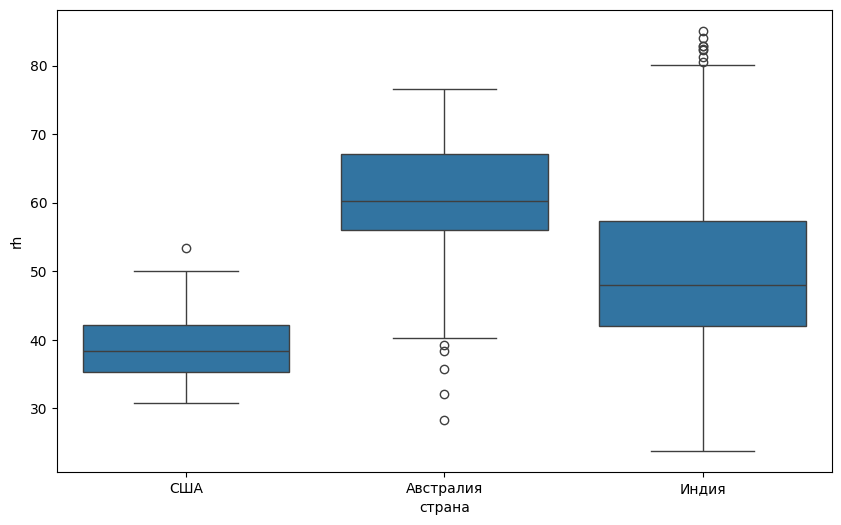

In [150]:
def graphs_visualization(df, col1, col2): 
    col1_type = df[col1].dtype # определяю тип колонки
    col2_type = df[col2].dtype # определяю тип колонки

    if col1_type == col2_type and col1_type != 'object': # здесь идет сравнение: если типы колонок равны и не являются обжектом, то строим диаграмму рассеяния
        plt.figure(figsize=(10, 6))
        plt.scatter(df[col1], df[col2], alpha=0.6)
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.grid()
        plt.show()
    elif col1_type == 'object': 
        if col2_type != 'object': 
            plt.figure(figsize=(10, 6))
            sns.boxplot(x=col1, y=col2, data=df)
            plt.show()
        else:
            pass # пока здесь стоит заглушка, не понятно, каким образом нарисовать информативную круговую диаграмму

            # fig, axs = plt.subplots(1, 2, figsize=(15, 5))
            # counts1 = df.groupby(col1)[col2].value_counts()
            # counts2 = df[col2].value_counts()
            # axs[0].pie(counts1, labels=counts1)
            # axs[1].pie(counts2, labels=counts2.index)
    elif col2_type == 'object':
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=col2, y=col1, data=df)
        plt.show()



graphs_visualization(df, 'rh', 'страна')